# Explanations 

First, in our diffusion model, we define a markovian noising process, where we gradually add noise. Then, we try to predict the noise backwards (with a neural net. that understands images).

We only predict the mean, and fix the variance based on the variance we defined in the forward-noising process (not learning a covariance).

***DDPM vs. DDIM***

DDIM allows us to formulate diffusion in a non-markovian way, so we can deterministacally sample and add noise. It is basically sampling one noise-vector, and using this to 'jump' to an arbitrary sample, instead of taking steps.

***? what is an intuitive explanation for how DDIMs vs DDPMS work, how can we formulate them, understand, and sample from them???***

Here is a visualization:

In [21]:
import torch
from PIL import Image
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0410593..1.019641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15299088..1.0732926].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23413625..1.122013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3114508..1.1680753].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38845342..1.2278792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46617916..1.2897481].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5449

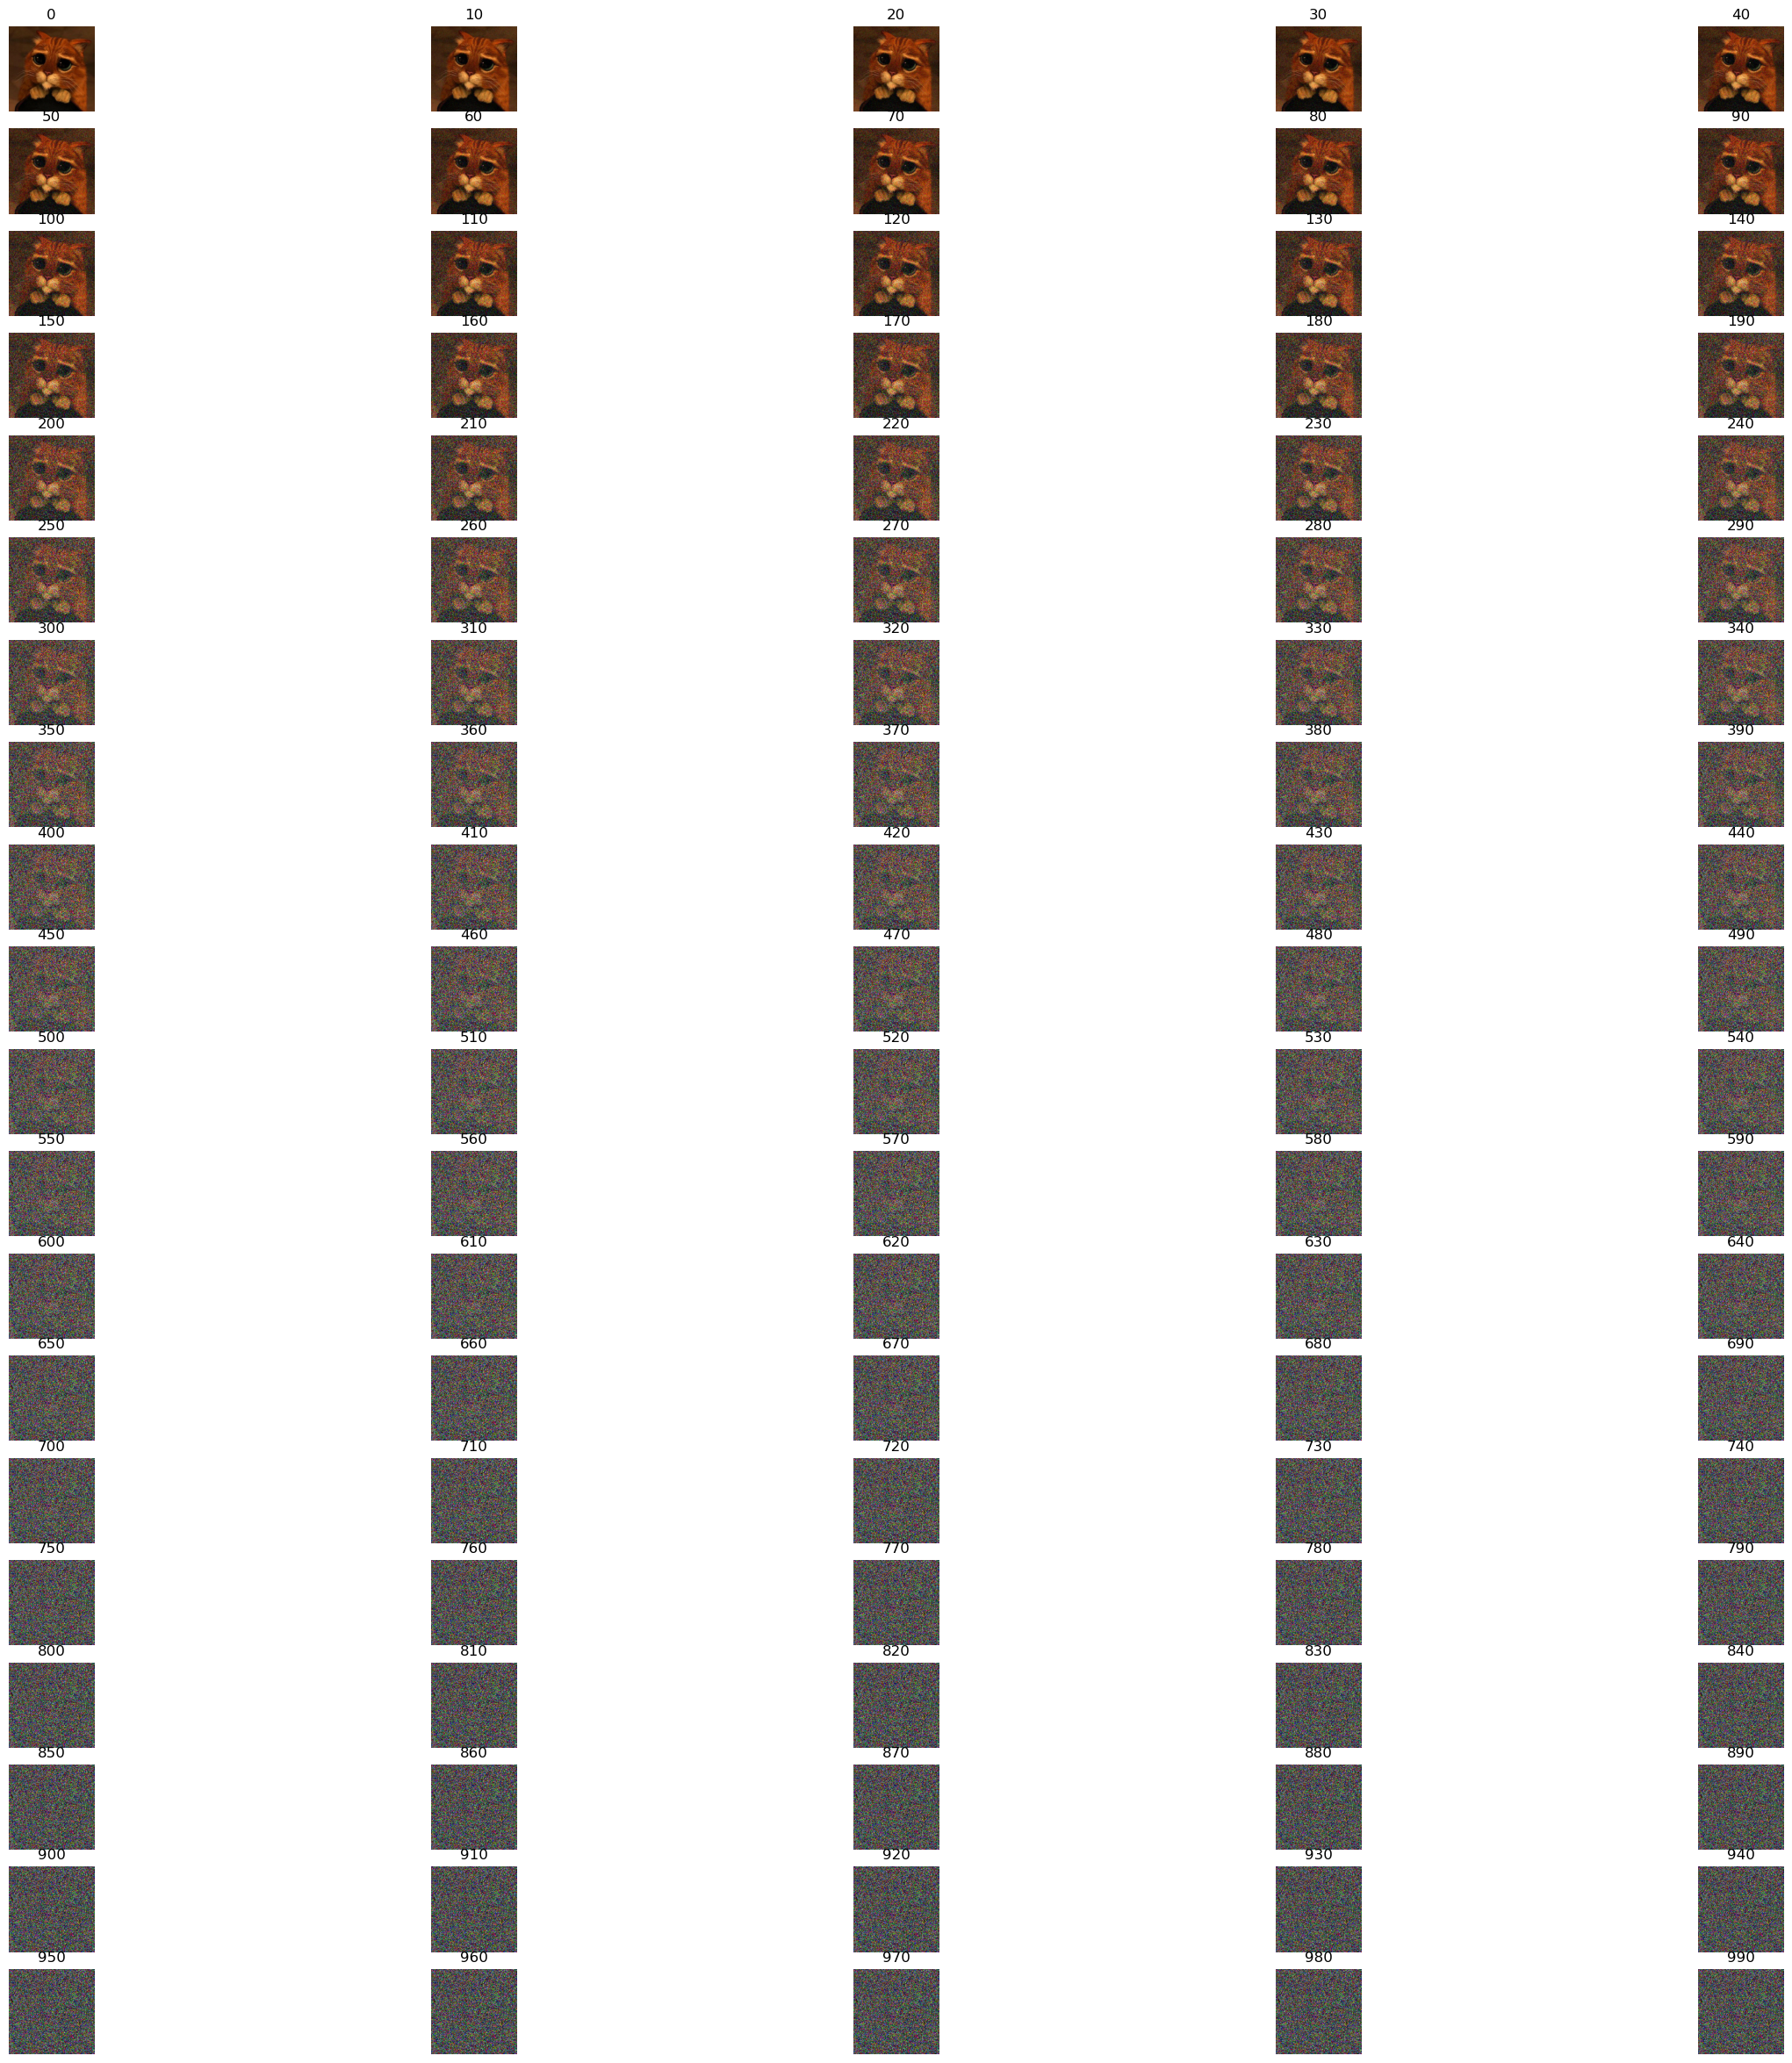

In [22]:
# We will be training our neural net. to predict the 
# noise that created an image (which is the same) as
# predicting the lower noising-step




image = Image.open('img.jpg')
to_tensor = torchvision.transforms.ToTensor()
image = to_tensor(image)


# showing all steps, or just current step
def add_noise(image,steps=100,current_step=None,scale=1.5):
    
    # alphas, betas, alpha_cumprod.
    # makes the noising exponentially faster
    # but on same-scale
    betas = torch.linspace(0.0001**(1/scale),0.02**(1/scale),steps)**scale
    alphas = 1-betas
    alphas_cumprod = torch.cumprod(alphas,dim=0)
    
    # normal distr.
    # DDIM sampling
    noise = torch.randn_like(image)
    
    if current_step is None:
        # having 10x less than steps!
        num_rows = steps // 50 + steps % 50
        fig,subplots = plt.subplots(num_rows,5)
        fig.set_size_inches(30,30)
        for i in range(steps // 10):
            
            alpha = alphas_cumprod[i*10]
            beta = 1-alpha
            noised_image = noise*beta**0.5 + image*alpha**0.5 
            subplots[i // 5][i % 5].imshow(noised_image.permute(1,2,0))
            subplots[i // 5][i % 5].set_title(f"{i*10}")
            subplots[i // 5][i % 5].axis("off")
        
    else:
        alpha = alphas_cumprod[current_step]
        beta = 1-alpha
        
        noised_image = noise*beta**0.5 + image*alpha**0.5 
        
        plt.imshow(noised_image.permute(1,2,0))
        


add_noise(image,1000,None)

    

## Learning Objective

In DDPM's, we want to predict the noise that makes up an image, at any arbitrary step. 

We acheive this loss objective, because we are actually trying to predict the mean of the previous noise-step (x_t-1), and this is made up of the ground-truth noise.

So when we plug this into a formula, we can get the mean, and then add back in the variance. And we could then continously sample; but all we care about for now is the training objective:
- Define a random timestep
- Define a noise-vector, add this to the image
- Do MSE loss, noise-vector is the target, and the models output given the noisy image, and the timestep is the prediction

> Note that the actual loss-formula tells us to weight more important/large noising steps more powerfully, however we ignore this, as at each step we want the model to be robust at predicting the noise, and the step itself shouldn't matter.

The reason we may want to do this, is because at earlier/more-noised steps, we want the model to be able to generate a variety, a of images, and then later on it will hone in on the image that was chosen in an earlier-step.

In [23]:
# very stupid model
model = lambda x: x

'''Adding random noise
to a batch corresponding to 
random-timesteps.'''

class DDPM:
    def __init__(self,steps,betas,scale):
        self.betas = torch.linspace(betas[0]**(1/scale),betas[1]**(1/scale),steps) ** (scale)
        self.alphas = 1-self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas,dim=0)
        self.steps= steps
        
    def add_random_noise(self,batch):
        # for each batch, add-noise,
        # and return noisy image + noise
        input_shape = batch.shape
        # easy to deal with
        batch = batch.view(input_shape[0],-1)
        noise = torch.randn_like(batch)
        # broadcast across dim=1
        steps = torch.randint(0,self.steps,size=(batch.shape[0],))
        
        # selecting from alpha bars
        # B, 1
        alpha_bars = self.alphas_cumprod[steps].view(-1,1)
        
        # adding according to noising process
        # std dev and mean
        noised_images = alpha_bars**0.5 * batch + (1-alpha_bars)**0.5 * noise
        noised_images = noised_images.view(input_shape)
        
        # step doesn't matter; predicting
        # same ground-truth noise!
        noise = noise.view(input_shape)
        return noised_images, noise
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.7662005..4.3188305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.8799505..4.2877364].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.58508..5.447051].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8113169..1.5552621].


torch.Size([4, 3, 280, 280])
torch.Size([4, 3, 280, 280])


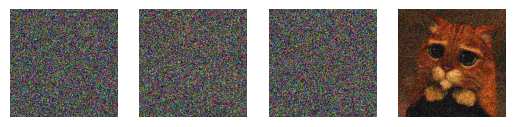

In [24]:
# testing out noiser
# with two noisings

images = torch.stack([image,image,image,image],dim=0)
ddpm = DDPM(1000,[0.0001,0.02],scale=1.5)

out = ddpm.add_random_noise(images)
print(out[0].shape)

fig,axes = plt.subplots(1,4)
axes[0].imshow(out[0][0].permute(1,2,0))
axes[1].imshow(out[0][1].permute(1,2,0))
axes[2].imshow(out[0][2].permute(1,2,0))
axes[3].imshow(out[0][3].permute(1,2,0))

for ax in axes:
    ax.axis('off')
    
print(out[1].shape)

In [25]:
# now, we would just calculate MSE loss 
# between the model and the actual noise!

'''As long as we have a good representation of what we want the model to denoise,
we should be able to test this intuition vs. practice, and set our scale parameter, or
use a different parameterization for our model.'''

'As long as we have a good representation of what we want the model to denoise,\nwe should be able to test this intuition vs. practice, and set our scale parameter, or\nuse a different parameterization for our model.'

> So, why DDPM in the first place? Well, since we need to sample from nothing (noise), but we also want to train the model to build-up our image, diffusion is great, because it allows us to understand our image at each step, and allows the model during inference to start by kind of predicting randomly, but gain a 'feel' for what the image is; alowing us to effectively 'sample' from the true distribution of images effectively.

The key is the models training to predict noise at *each* step

# ***Learning variance***

In the original DDPM paper, variance was set to either β or β~, which correspond to the upper, and lower-bounds of the variance. The upper-bound works best when q(x_0) is normally distributed, while the lower-bound works when q(x_0) is deterministic at one-point. However, one may ask: why are there even upper or lower bounds on variance, if we know how much noise we are adding (and therefore removing) at each-step? 


Here is the original derivation for the upper/lower-bounds:
![form5](images/form5.jpg)

> How I understand this, is that when we start with a normal distribution, in each step we are removing some of the original noise, and therefore we should add this noise back-in. While for the deterministic case, we remove some of the information (and no-noise), so less-noise should be added. 

But in the backward pass (de-noising), shouldn't we just add back the noise we already specified at a given-step (β)? Well, this does not account for the fact that there may be some noise in the current mean-prediction, or it may be deterministic. If it was deterministic, we wouldn't want to add too much noise, because the mean is more certain; we wouldn't need to capture more distribution due to our uncertainty. This allows our model to be flexible, and 'over-predict' if it deems it necessary, and is sure.

#### ***Loss-function***

The way that we can predict the variance, is by putting a stop-gradient on the original loss-objective mean, and adding this new term (weighted) to try to learn an optimal variance given a timestep and noisy-image. Here is the formula for the loss:

![form6](images/form6.png)

where L_VLB is the original loss-function, and we must use this, because it actually involves optimizing our variance-term. The actual loss will be the KL divergence between the two distrbituions q and p, and this should allow the model to learn the variance in the de-noising process to be able to better model the distribution of data.

Remember, when optimizing this, we can simply approximate it with the MSE loss (because gaussian) between the predicted image (with variance), and the actual-image, weighted by some-amount.

our output variance can be learned as:

![form4](images/form4.png)

where V is the output of our neural network for each latent random-variable. We parameterize it this way so it doesn't explode.


Here are the formulas for our full VLB (remember, we want the KL divergence between the q and p distributions):

![form7](images/form7.png)

![form8](images/form8.png)

The intuition for the above formula, is that our ground-truth variance is the 'actual' variance, and any extra variance (bounded by forward-process β) could help us account for the innacuracy of our mean.

In [26]:
# DDPM w/ hybrid-loss 

class DDPM:
    def __init__(self,steps,betas,scale,loss2_weight=0.001):
        
        self.loss2_weight = loss2_weight
        self.betas = torch.linspace(betas[0]**(1/scale),betas[1]**(1/scale),steps) ** scale
        self.alphas = 1-self.betas
        self.alphas_sqrt = torch.sqrt(self.alphas)
        
        self.alphas_cumprod = torch.cumprod(self.alphas,dim=0)
        self.betas_cumprod = 1 - self.alphas_cumprod
        
        # for quick-compute
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_betas_cumprod = torch.sqrt(self.betas_cumprod)
        
        
        self.steps= steps
        
    def add_random_noise(self,batch):
        # for each batch, add-noise,
        # and return noisy image + noise
        input_shape = batch.shape
        # easy to deal with
        batch = batch.view(input_shape[0],-1)
        noise = torch.randn_like(batch)
        # broadcast across dim=1
        steps = torch.randint(0,self.steps,size=(batch.shape[0],))
        
        # selecting from alpha bars
        # B, 1
        alpha_bars = self.alphas_cumprod[steps].view(-1,1)
        
        # adding according to noising process
        # std dev and mean
        noised_images = alpha_bars**0.5 * batch + (1-alpha_bars)**0.5 * noise
        noised_images = noised_images.view(input_shape)
        
        # step doesn't matter; predicting
        # same ground-truth noise!
        noise = noise.view(input_shape)
        return noised_images, noise
    
    def hybrid_loss(self,model_out,noise,real_image,t,noised_image):
        # getting both of our outputs
        pred_noise,pred_var = model_out.chunk(2,dim=-2)
        
        # simple-loss
        l_simple = torch.mean((pred_noise-noise)**2)
        
        # calculating ground-truth mean and
        # predicted-mean (same but diff.-noise)
        pred_mean = (1/ self.alphas_sqrt[t]) * \
            (noised_image-(self.betas[t]/self.sqrt_betas_cumprod[t])*pred_noise)
        real_mean = (1/ self.alphas_sqrt[t]) * \
            (noised_image-(self.betas[t]/self.sqrt_betas_cumprod[t])*noise)
        
        # lower/upper bds of beta
        lower_beta = self.betas[t] # also 'ground-truth'
        upper_beta = self.betas[t] * self.betas_cumprod[t-1] / self.betas_cumprod[t]
        pred_var = torch.exp(torch.log(lower_beta)*pred_var + torch.log(upper_beta)*(1-pred_var))
        
        # full-loss,
        # should broadcast to B,shape_img
        dkl_loss = 0.5 * (lower_beta/pred_var + (pred_mean-real_mean)/pred_var - 1 + torch.log(pred_var/lower_beta))
        hybrid_loss = dkl_loss*self.loss2_weight + l_simple
        
        return hybrid_loss
    

# ***DDIM inference***

DDIM allows us to deterministically sample an arbitrary step in the model when we predict the noise at a step. Basically, we define a non-markovian noising process that is exactly equal to our objective in the markovian one (DPPM).

## ***Paper-notes***

- The authors promise a 10x-50x speedup, along with more accurate images, and a way to get deterministic sampling with DDIM.

- Furthermore, they say that the DDIM inference-formulation allows for similar initial latent-variables (noise) to actually have similar high-level features! This means we can interpolate in latent-space.

The key idea behind DDIM's, stems from the fact that the training objective only relies on the noised image with respect to the original image (q(x_t|x_0)), and not the entire noising process. Therefore, we can actually pick different noising processes for our inference, that still allign with the training objective!

### ***Formula***

The key formula is the actual re-formulation of our noising process. The authors formulate each step in the noising process with: q(x_t-1|x_t,x_0). They make sure this always adhere to the training objective, which relies on q(x_t|x_0) to be constant. This de-noising step is basically saying that we should get the next step by factoring in some of x_t and some of x_0, and then some noise (which we can scale).

The authors then, allow us to scale how much of q(x_t) factors into q(x_t-1), vs. how much random-noise is factored in. This basically allows us the *keep* some of the original noise; on one extreme (DDPM) we don't keep any of the original noise. On the other, we always keep it, and we can exactly predict x_t-1 from x_t.

![formula](images/form1.png)

> Intuitively, since we dont replace the 'randomness', we can deterministically sample from our model, and similar noises should have small variations, since we don't continually add-back noise!

The authors then go on to prove that the training objectives are the same between DDIM and DDPM.

Then we can take our formulation of the changed-denoising process, and begin to denoise!

![formula2](images/form2.png)

as we can see, we use some of the previous noise (however much we pick), and some deterministic sampling. If we'd wanted to 'interpolate' in the latent-space, we'd ideally choose a low noise (σ) score. when σ is zero, we have a DDIM model.


### 'Accelerated' Generation Process

Since we've discovered that we can formulate the inference (denosing) in any way, as long as it matches the training-objective, we can define a shorter noising-process, as long as it matches q(x_t | x_0) = same as DDPM with full T.

Bascially, we train with an arbitrarily large number of sampling-steps, but we actually only inference with a small subset of these steps. And, an intution for this, is that we use the same predicted x_0 to just denoise less-gradually. This way, we can train fast, while still doing most of the diffusion-work (since the model is conditioned to predict the best x_0 anyway).


### Inference
Lastly, before we inference, we can just define our σ hyper-parameter, and then define our standard deviation as follows (for any number of steps we decide to characterize our distribution with):

![form3](images/form3.png)


#### ***Now, let's test out this new formulation of inference on our trained DiT model!***

In [27]:
noncom = torch.linspace(start=0.0001,end=0.002,steps=100)
alphas = torch.cumprod(1-noncom,dim=0)

alphas

tensor([0.9999, 0.9998, 0.9996, 0.9995, 0.9993, 0.9991, 0.9989, 0.9987, 0.9984,
        0.9981, 0.9978, 0.9975, 0.9972, 0.9969, 0.9965, 0.9961, 0.9957, 0.9953,
        0.9948, 0.9944, 0.9939, 0.9934, 0.9929, 0.9923, 0.9918, 0.9912, 0.9906,
        0.9900, 0.9894, 0.9887, 0.9880, 0.9874, 0.9867, 0.9859, 0.9852, 0.9844,
        0.9836, 0.9829, 0.9820, 0.9812, 0.9804, 0.9795, 0.9786, 0.9777, 0.9768,
        0.9758, 0.9749, 0.9739, 0.9729, 0.9719, 0.9709, 0.9698, 0.9687, 0.9677,
        0.9666, 0.9654, 0.9643, 0.9632, 0.9620, 0.9608, 0.9596, 0.9584, 0.9571,
        0.9559, 0.9546, 0.9533, 0.9520, 0.9507, 0.9494, 0.9480, 0.9467, 0.9453,
        0.9439, 0.9425, 0.9410, 0.9396, 0.9381, 0.9366, 0.9351, 0.9336, 0.9321,
        0.9306, 0.9290, 0.9274, 0.9258, 0.9242, 0.9226, 0.9210, 0.9193, 0.9177,
        0.9160, 0.9143, 0.9126, 0.9109, 0.9091, 0.9074, 0.9056, 0.9039, 0.9021,
        0.9003])

In [28]:
# formulation of DDIM
# will add to sampler class
'''Given our prediction of the noise (which we gen x_0 from), 
and the previous sample, we get the next step, and add in some
random noise (if σ != 0 and we're not using DDIM).

For now, recreating alphas/betas cumprod. In the DDIM paper, alphas were treated
as the cumprod, so we'll just do the same.

We can specify the total number of steps, and lower this
when we decide to sample with a shorter chain.
'''

TODO: Make variance alligned with skipping-steps for fast-inference (and mean!!!) -> w/ pred-var!
import torch
class DDIM:
    def __init__(self,device,total_steps=1000,betas=[0.002,0.01],n=0,inference_steps=50,weight=1.5):
        # getting alpha (which is cumprod?)
        self.device=device
        betas = torch.linspace(betas[0]**(1/weight),betas[1]**(1/weight),total_steps,device=device,dtype=torch.float32)**(weight)
        self.alphas = torch.cumprod(1-betas,dim=0)
        self.inference_steps = inference_steps
        self.total_steps = total_steps
        self.n = n# NOT IN USE
        
    # model should be in eval mode,
    # using it to remove noise
    # at specified steps.
    # stop at last step (use)
    # obtained x_0
    def denoise(self,model,label,image = None):
        step_size = self.total_steps // self.inference_steps
        all_steps = torch.arange(0,self.total_steps,device=self.device)
        steps = torch.flip(all_steps[::step_size],dims=[-1])
        if image is None:
            image = torch.randn([1,4,32,32],device=self.device)
        for s in range(len(steps)-1):
            # viewing with extra b-dim
            current_t = steps[s].unsqueeze(0)
            eps_theta,pred_var = model(image,current_t,label).chunk(2,dim=1)
            eps_theta,pred_var = eps_theta.squeeze(1),pred_var.squeeze(1)
            
            # 'prev'/next step in denoise
            alpha_next = self.alphas[steps[s+1]]
            alpha_current = self.alphas[steps[s]]
 
            # std-formula
            std = self.n*((1-alpha_next)/(1-alpha_current))**0.5 * (1-alpha_current/alpha_next)**0.5
            # predicting our ground-truth from noise...
            pred_x0 = alpha_next**0.5 * ((image-((1-alpha_current)**0.5*eps_theta))/alpha_current**0.5)
            dir_xt = (1-alpha_next-std**2)**0.5 * eps_theta
            rand_noise = std*torch.randn_like(pred_x0,device=self.device)
            
            # predicted image, doing again!
            if s-1 == len(steps):
                # in case last-step
                image = pred_x0
            else:
                image = pred_x0+dir_xt+rand_noise
                
        return image

        


In [29]:
import huggingface_hub
import torch
import sys
import os
sys.path.append(os.path.abspath('../data'))
sys.path.append(os.path.abspath('../VAE'))
sys.path.append(os.path.abspath('../DDPM'))
sys.path.append(os.path.abspath('../DiT'))
sys.path.append(os.path.abspath('../config'))
import yaml

with open('../config/config.yaml') as file:
    config = yaml.safe_load(file)


import dataloader
import get_vae
import sampler
import transformer


betas=[0.0001,0.02]
steps = 1000

dataset = dataloader.ImageDataset(None,'raw_images',
                                  label_folder='../data/label_folder',
                                  im_extension='jpeg',
                                  use_latents=True,
                                  latent_folder='../data/latent_folder_sdxl',
                                  device='cpu')
full_vae, encoder = get_vae.get_vae()

# diffusion-process
path = os.path.abspath('../weights.pt')
model = transformer.DiT(config['dit_params'])
model.load_state_dict(torch.load(path))
model.to('cuda').eval()

image_noise = torch.randn([1,4,32,32],device='cuda')
gen_model = DDIM(device='cuda',total_steps=1000,betas=betas,n=0.0,inference_steps=50)
full_vae.to('cuda')
print("done")

c:\Users\charl\OneDrive\Machine Learning\DiT Implementation\data\dataloader.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.images = torch.load(full_path,map_loca

done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4132678..1.009929].


Text(0.5, 1.0, 'Label = tench')

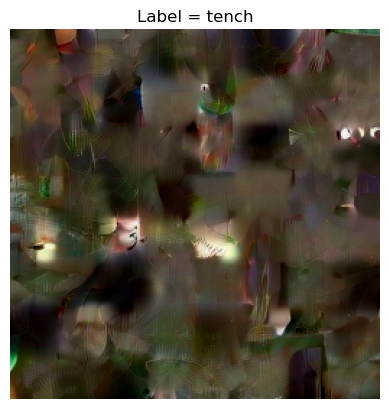

In [30]:


# image of tench!
label = torch.tensor([0]).to('cuda')
with torch.no_grad():
    img_gen = gen_model.denoise(model=model,image=image_noise,label=label)
    img = full_vae.decode(img_gen)

img = img.cpu()
img = img.squeeze()
plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.title("Label = tench")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4132678..1.009929].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3220204..1.0304484].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48526317..1.0377471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57011676..1.0157082].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5899535..1.0803013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71735746..1.1106298].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4805

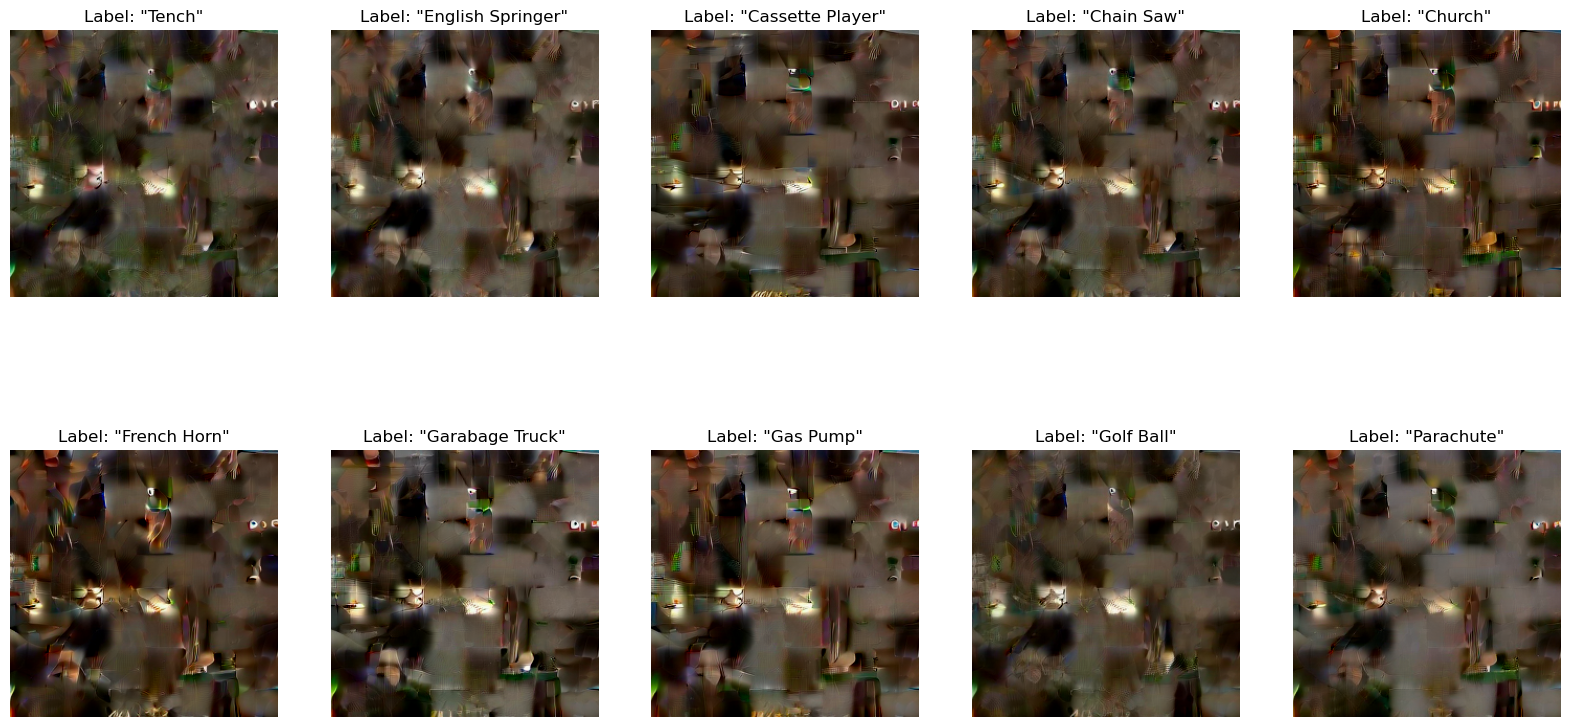

In [31]:
label_map = {
    0:"Tench",
    1:"English Springer",
    2: "Cassette Player",
    3:"Chain Saw",
    4:"Church",
    5:"French Horn",
    6:"Garabage Truck",
    7:"Gas Pump",
    8:"Golf Ball",
    9:"Parachute"
}


fig,axes = plt.subplots(2,5)
fig.set_size_inches(20,10)
for i,l in enumerate(label_map.keys()):
    label = torch.tensor([i]).to('cuda')
    with torch.no_grad():
        img_gen = gen_model.denoise(model=model,image=image_noise,label=label)
        img = full_vae.decode(img_gen).cpu().squeeze(0)
        axes[i//5][i%5].imshow(img.permute(1,2,0))
        axes[i//5][i%5].set_title(f'Label: "{label_map[l]}"')
        axes[i//5][i%5].axis('off')

# Guidance
We can train the model to take some text tokens (Ideally from a pre-trained model), or some other embedding (like a class embedding) for the model to learn to generate images conditionally. This is mathematically just a conditional distribution, and the model will learn it like it would learn to approximate another distribution (in the DiT we make the class embeddings play a role in AdaLN params).

### CFG
Classifier-free guidance is a way to beef-up the capability of our model; we can, through each de-noising step during inference do the following:
- Apply formula: